# Visão Computacional: O Guia Completo - Classificação de emoções

# Importação das bibliotecas

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

# Carregamento das imagens

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Cursos - recursos/Visão Computacional Guia Completo/Datasets/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

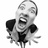

In [ ]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Angry/1003.jpg')

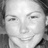

In [ ]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Happy/1.jpg')

# Bases de treinamento e teste

In [ ]:
gerador_treinamento = ImageDataGenerator(rescale=1./255,
                                         rotation_range=7,
                                         horizontal_flip=True,
                                         zoom_range=0.2)
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/fer2013/train',
                                                              target_size = (48, 48),
                                                              batch_size = 16,
                                                              class_mode = 'categorical',
                                                              shuffle = True)

Found 28709 images belonging to 7 classes.


In [ ]:
dataset_treinamento.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
np.unique(dataset_treinamento.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [ ]:
dataset_treinamento.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

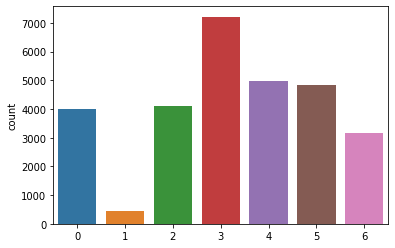

In [ ]:
sns.countplot(x = dataset_treinamento.classes);

In [ ]:
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


# Construção e treinamento da rede neural

In [ ]:
2*2*2*32

256

In [ ]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
numero_detectores = 32
numero_classes = 7
largura, altura = 48, 48
epocas = 70

network = Sequential()

network.add(Conv2D(filters=numero_detectores, kernel_size=(3,3), activation='relu', padding='same', input_shape=(largura, altura, 3)))
network.add(BatchNormalization())
network.add(Conv2D(filters=numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(filters=2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(filters=2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(filters=2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(filters=2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(filters=2*2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(filters=2*2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(units=2 * numero_detectores, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(units=2 * numero_detectores, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(units=numero_classes, activation='softmax'))
print(network.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
network.fit(dataset_treinamento, epochs=epocas)

Epoch 1/70
1795/1795 [==============================] - 38s 20ms/step - loss: 2.0256 - accuracy: 0.2246
Epoch 2/70
1795/1795 [==============================] - 37s 21ms/step - loss: 1.5614 - accuracy: 0.3895
Epoch 3/70
1795/1795 [==============================] - 37s 20ms/step - loss: 1.4009 - accuracy: 0.4619
Epoch 4/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.3134 - accuracy: 0.5061
Epoch 5/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.2743 - accuracy: 0.5183
Epoch 6/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.2236 - accuracy: 0.5400
Epoch 7/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.1825 - accuracy: 0.5598
Epoch 8/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.1613 - accuracy: 0.5653
Epoch 9/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.1426 - accuracy: 0.5772
Epoch 10/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.1185 - accuracy: 0.5844
Epoch 11/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.0845 - accuracy: 0.5962
Epoch 12/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.0678 - accuracy: 0.6065
Epoch 13/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.0518 - accuracy: 0.6136
Epoch 14/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.0405 - accuracy: 0.6152
Epoch 15/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.0391 - accuracy: 0.6178
Epoch 16/70
1795/1795 [==============================] - 35s 20ms/step - loss: 1.0083 - accuracy: 0.6310
Epoch 17/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.0001 - accuracy: 0.6324
Epoch 18/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.9924 - accuracy: 0.6372
Epoch 19/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.9713 - accuracy: 0.6461
Epoch 20/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.9600 - accuracy: 0.6492
Epoch 21/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.9497 - accuracy: 0.6501
Epoch 22/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.9480 - accuracy: 0.6524
Epoch 23/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.9347 - accuracy: 0.6624
Epoch 24/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.9208 - accuracy: 0.6614
Epoch 25/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.9181 - accuracy: 0.6632
Epoch 26/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.9183 - accuracy: 0.6625
Epoch 27/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.9082 - accuracy: 0.6725
Epoch 28/70
1795/1795 [==============================] - 36s 20ms/step - loss: 0.9078 - accuracy: 0.6683
Epoch 29/70
1795/1795 [==============================] - 36s 20ms/step - loss: 0.8960 - accuracy: 0.6748
Epoch 30/70
1795/1795 [==============================] - 36s 20ms/step - loss: 0.8962 - accuracy: 0.6717
Epoch 31/70
1795/1795 [==============================] - 36s 20ms/step - loss: 0.8926 - accuracy: 0.6716
Epoch 32/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.8802 - accuracy: 0.6754
Epoch 33/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.8654 - accuracy: 0.6854
Epoch 34/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.8696 - accuracy: 0.6851
Epoch 35/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.8498 - accuracy: 0.6913
Epoch 36/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.8514 - accuracy: 0.6937
Epoch 37/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.8279 - accuracy: 0.6985
Epoch 38/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.8395 - accuracy: 0.6933
Epoch 39/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.8263 - accuracy: 0.7002
Epoch 40/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.8215 - accuracy: 0.7015
Epoch 41/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.8237 - accuracy: 0.6977
Epoch 42/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.8037 - accuracy: 0.7068
Epoch 43/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.8071 - accuracy: 0.7090
Epoch 44/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.8033 - accuracy: 0.7076
Epoch 45/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.8166 - accuracy: 0.7033
Epoch 46/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7820 - accuracy: 0.7159
Epoch 47/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7790 - accuracy: 0.7176
Epoch 48/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7892 - accuracy: 0.7157
Epoch 49/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7482 - accuracy: 0.7267
Epoch 50/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7596 - accuracy: 0.7236
Epoch 51/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7584 - accuracy: 0.7245
Epoch 52/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7694 - accuracy: 0.7243
Epoch 53/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7471 - accuracy: 0.7341
Epoch 54/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7522 - accuracy: 0.7275
Epoch 55/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7383 - accuracy: 0.7290
Epoch 56/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7521 - accuracy: 0.7292
Epoch 57/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7397 - accuracy: 0.7287
Epoch 58/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7218 - accuracy: 0.7419
Epoch 59/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7223 - accuracy: 0.7429
Epoch 60/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7106 - accuracy: 0.7436
Epoch 61/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7170 - accuracy: 0.7418
Epoch 62/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.7200 - accuracy: 0.7405
Epoch 63/70
1795/1795 [==============================] - 37s 21ms/step - loss: 0.7152 - accuracy: 0.7424
Epoch 64/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.6988 - accuracy: 0.7485
Epoch 65/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.6973 - accuracy: 0.7513
Epoch 66/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.6906 - accuracy: 0.7524
Epoch 67/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.6973 - accuracy: 0.7516
Epoch 68/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.6821 - accuracy: 0.7492
Epoch 69/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.6768 - accuracy: 0.7601
Epoch 70/70
1795/1795 [==============================] - 38s 21ms/step - loss: 0.6884 - accuracy: 0.7520
<tensorflow.python.keras.callbacks.History at 0x7f0db020b550>

# Salvar e carregar a rede neural

In [ ]:
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights_emotions.hdf5')

In [ ]:
with open('/content/drive/MyDrive/Cursos - recursos/Visão Computacional Guia Completo/Weights/network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_8_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_8", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/drive/MyDrive/Cursos - recursos/Visão Computacional Guia Completo/Weights/weights_emotions.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
network_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)       

# Avaliação da rede neural

In [ ]:
network_loaded.evaluate(dataset_teste)

3589/3589 [==============================] - 24s 7ms/step - loss: 1.5148 - accuracy: 0.5779


[1.5148497819900513, 0.5778768658638]

In [ ]:
previsoes = network_loaded.predict(dataset_teste)
previsoes

array([[9.13990378e-01, 5.24318451e-03, 2.00649798e-02, ...,
        7.55342934e-03, 3.91560532e-02, 1.23086823e-02],
       [8.34895134e-01, 1.31148292e-04, 1.60493851e-01, ...,
        8.83346307e-04, 3.42258788e-03, 1.44679390e-07],
       [9.68744576e-01, 7.42951699e-04, 1.70952473e-02, ...,
        1.25664100e-03, 7.57123251e-03, 4.92688327e-04],
       ...,
       [1.75535097e-03, 4.70190134e-05, 4.10513133e-02, ...,
        1.66567194e-03, 2.93832272e-03, 9.52457964e-01],
       [2.91053345e-03, 4.30335567e-05, 6.92671165e-02, ...,
        3.61311793e-01, 3.13798035e-03, 5.30261636e-01],
       [2.68193595e-02, 2.26625963e-03, 1.13005705e-01, ...,
        4.77516372e-03, 7.12133711e-03, 8.45583379e-01]], dtype=float32)

In [ ]:
previsoes = np.argmax(previsoes, axis = 1)
previsoes

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
dataset_teste.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.5778768459180831

In [ ]:
dataset_teste.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)
cm

array([[276,   8,  53,  14,  64,  71,   5],
       [ 13,  36,   2,   1,   2,   1,   0],
       [ 51,   3, 244,  19,  78,  91,  42],
       [ 10,   2,  16, 775,  46,  18,  12],
       [ 87,  11,  84, 160, 115, 111,  58],
       [ 44,   1,  53,  25, 146, 319,   6],
       [  4,   3,  56,  25,  14,   5, 309]])

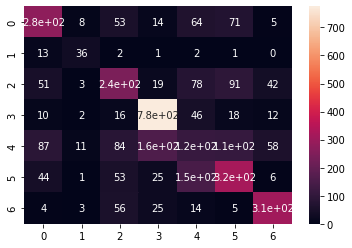

In [ ]:
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       491
           1       0.56      0.65      0.61        55
           2       0.48      0.46      0.47       528
           3       0.76      0.88      0.82       879
           4       0.25      0.18      0.21       626
           5       0.52      0.54      0.53       594
           6       0.72      0.74      0.73       416

    accuracy                           0.58      3589
   macro avg       0.55      0.57      0.56      3589
weighted avg       0.56      0.58      0.56      3589



# Classificação de uma única imagem

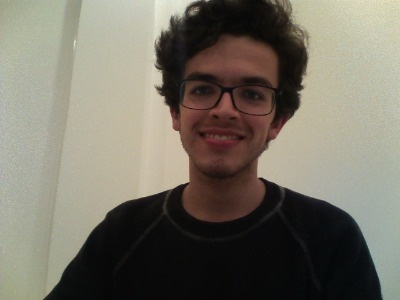

In [ ]:
imagem = cv2.imread('/content/drive/MyDrive/Cursos - recursos/Visão Computacional Guia Completo/Images/gabriel.png')
cv2_imshow(imagem)

In [ ]:
imagem.shape

(300, 400, 3)

In [ ]:
detector_face = cv2.CascadeClassifier('/content/drive/MyDrive/Cursos - recursos/Visão Computacional Guia Completo/Cascades/haarcascade_frontalface_default.xml')

In [ ]:
imagem_original = imagem.copy()
deteccoes = detector_face.detectMultiScale(imagem_original)

In [ ]:
deteccoes

array([[162,  40, 128, 128]], dtype=int32)

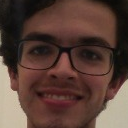

In [ ]:
roi = imagem[40:40 + 128, 162:162 + 128]
cv2_imshow(roi)

In [ ]:
roi.shape

(128, 128, 3)

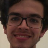

In [ ]:
roi = cv2.resize(roi, (48,48))
cv2_imshow(roi)

In [ ]:
roi.shape

(48, 48, 3)

In [ ]:
roi

array([[[ 28,  32,  37],
        [ 22,  28,  34],
        [ 33,  37,  42],
        ...,
        [ 12,  16,  17],
        [ 16,  21,  25],
        [ 16,  25,  30]],

       [[ 27,  31,  36],
        [ 31,  36,  41],
        [ 32,  36,  41],
        ...,
        [ 11,  16,  19],
        [ 13,  19,  24],
        [ 17,  25,  28]],

       [[ 27,  31,  36],
        [ 30,  34,  39],
        [ 26,  30,  35],
        ...,
        [ 12,  17,  20],
        [ 14,  20,  25],
        [ 20,  25,  27]],

       ...,

       [[162, 185, 197],
        [166, 188, 200],
        [166, 188, 200],
        ...,
        [162, 181, 188],
        [162, 182, 188],
        [161, 180, 187]],

       [[160, 184, 196],
        [165, 187, 199],
        [166, 188, 200],
        ...,
        [161, 180, 187],
        [162, 181, 187],
        [161, 180, 187]],

       [[160, 184, 196],
        [163, 187, 199],
        [165, 187, 199],
        ...,
        [160, 179, 186],
        [161, 180, 187],
        [162, 181, 188]]

In [ ]:
roi = roi / 255
roi

array([[[0.10980392, 0.1254902 , 0.14509804],
        [0.08627451, 0.10980392, 0.13333333],
        [0.12941176, 0.14509804, 0.16470588],
        ...,
        [0.04705882, 0.0627451 , 0.06666667],
        [0.0627451 , 0.08235294, 0.09803922],
        [0.0627451 , 0.09803922, 0.11764706]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.12156863, 0.14117647, 0.16078431],
        [0.1254902 , 0.14117647, 0.16078431],
        ...,
        [0.04313725, 0.0627451 , 0.0745098 ],
        [0.05098039, 0.0745098 , 0.09411765],
        [0.06666667, 0.09803922, 0.10980392]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.11764706, 0.13333333, 0.15294118],
        [0.10196078, 0.11764706, 0.1372549 ],
        ...,
        [0.04705882, 0.06666667, 0.07843137],
        [0.05490196, 0.07843137, 0.09803922],
        [0.07843137, 0.09803922, 0.10588235]],

       ...,

       [[0.63529412, 0.7254902 , 0.77254902],
        [0.65098039, 0.7372549 , 0.78431373],
        [0.65098039, 0

In [ ]:
roi.shape

(48, 48, 3)

In [ ]:
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 48, 48, 3)

In [ ]:
probs = network_loaded.predict(roi)
probs

array([[5.2841852e-04, 1.1444085e-06, 1.2489489e-03, 8.9390182e-01,
        1.0206479e-01, 2.1787020e-03, 7.6220953e-05]], dtype=float32)

In [ ]:
previsao = np.argmax(probs)
previsao

3

In [ ]:
dataset_teste.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

# Classificação de múltiplas imagens

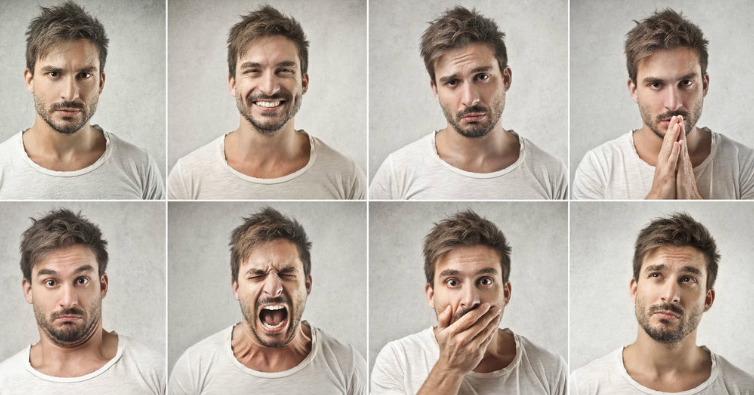

In [ ]:
imagem = cv2.imread('/content/drive/MyDrive/Cursos - recursos/Visão Computacional Guia Completo/Images/faces_emotions.png')
cv2_imshow(imagem)

In [ ]:
deteccoes = detector_face.detectMultiScale(imagem)
deteccoes

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

In [ ]:
dataset_teste.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

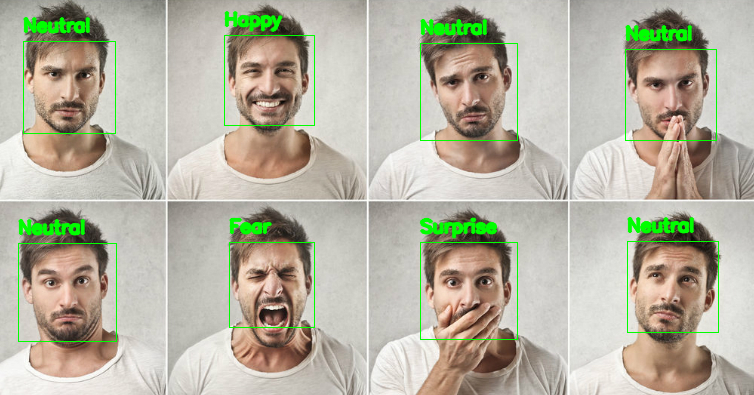

In [ ]:
for (x, y, w, h) in deteccoes:
  #print(x, y, w, h)
  cv2.rectangle(imagem, (x, y), (x + w, y + h), (0,255,0), 1)
  roi = imagem[y:y + h, x:x + w]
  #cv2_imshow(roi)
  roi = cv2.resize(roi, (48,48))
  #cv2_imshow(roi)
  roi = roi / 255
  roi = np.expand_dims(roi, axis = 0)
  #print(roi.shape)
  previsao = network_loaded.predict(roi)
  #print(previsao)
  cv2.putText(imagem, emotions[np.argmax(previsao)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
cv2_imshow(imagem)

# Classificação de emoções em vídeos

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Cursos - recursos/Visão Computacional Guia Completo/Videos/emotion_test01.mp4')
conectado, video = cap.read()
print(conectado, video.shape)

True (360, 640, 3)


In [ ]:
# fourcc.org
save_path = '/content/drive/MyDrive/Cursos - recursos/Visão Computacional Guia Completo/Videos/emotion_test01_result.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
output_video = cv2.VideoWriter(save_path, fourcc, fps, (video.shape[1], video.shape[0]))

In [ ]:
while (cv2.waitKey(1) < 0):
  conectado, frame = cap.read()
  if not conectado:
    break
  deteccoes = detector_face.detectMultiScale(frame, scaleFactor=1.2,minNeighbors=5, minSize=(30,30))
  if len(deteccoes) > 0:
    for (x, y, w, h) in deteccoes:
      frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,0), 2)
      roi = frame[y:y + h, x:x + w]
      roi = cv2.resize(roi, (48,48))
      roi = roi / 255
      roi = np.expand_dims(roi, axis = 0)
      previsao = network_loaded.predict(roi)

      if previsao is not None:
        resultado = np.argmax(previsao)
        cv2.putText(frame, emotions[resultado], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

  cv2_imshow(frame)
  output_video.write(frame)

print('Terminou!')
output_video.release()
cv2.destroyAllWindows()